In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm


import multiprocessing as mp

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [4]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'

num_gpus = 2
gpu_start = 6
num_workers = 3 * num_gpus
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

bs = 32 * num_gpus 
BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IM_FOLDER = V5_IMAGE_DIR + "/trn_full_rgb/"
FMT_VALTEST_IM_FOLDER = V5_IMAGE_DIR + "/test_full_rgb/"

FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
# FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
# FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MASK_STORE = V5_IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = V5_IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_IMMEAN = V5_IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

## Preprocessing

In [5]:
# datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
# !python code/v5_im-full_rgb.py preproc_train {datapaths[1]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[3]}

In [7]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_train {datapaths[2]}

In [8]:
# for d in datapaths: print(d, end=' ')

In [9]:
# !parallel python code/v5_im-full_rgb.py preproc_train {} ::: data/train/AOI_2_Vegas_Train data/train/AOI_3_Paris_Train data/train/AOI_4_Shanghai_Train data/train/AOI_5_Khartoum_Train

In [10]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def get_data(area_id, is_test, max_workers=3):
    prefix = area_id_to_prefix(area_id)
    fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) if is_test else FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
    df_train = pd.read_csv(fn_train)
    
    fn_im = FMT_VALTEST_MASK_STORE.format(prefix) if is_test else FMT_VALTRAIN_MASK_STORE.format(prefix)
    y_val = np.empty((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 1))
    with tb.open_file(fn_im, 'r') as f:                                         
        for i, image_id in tqdm.tqdm_notebook(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0], desc='ims'):
            fn = '/' + image_id
            y_val[i] = np.array(f.get_node(fn))[..., None]
            
    fn_im = FMT_VALTEST_IM_FOLDER if is_test else FMT_VALTRAIN_IM_FOLDER
    X_val = np.empty((df_train.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3))
    if max_workers == 1:
        for i, image_id in tqdm.tqdm_notebook(enumerate(df_train.ImageId.tolist()), total=df_train.shape[0], desc='ims'):
            X_val[i] = plt.imread(fn_im + image_id + '.png')[...,:3]
    else:
        with ThreadPoolExecutor(max_workers=max_workers) as e:
            gen = e.map(plt.imread, [fn_im + image_id + '.png' for image_id in df_train.ImageId.tolist()])
            for i, im in enumerate(gen):
                X_val[i] = im[...,:3]
#         im = np.moveaxis(im, -1, 0)

    X_val, y_val = X_val.astype('float'), y_val.astype('float')
    return X_val, y_val

In [13]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_data(area_id, False)
#     print(trn_x.shape, trn_y.shape)
#     trn_x = np.moveaxis(trn_x, 1, -1).astype('float') # --> [bs, h, w, ch]
#     trn_y = np.moveaxis(trn_y, 1, -1).astype('float')

#     print(trn_x.shape, trn_y.shape)
    trn_y = np.broadcast_to(trn_y, [trn_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])

    val_x, val_y = get_data(area_id, True)
#     val_x = val_x[:,:3]
#     val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]
#     val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, [val_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])
               
    return (trn_x,trn_y), (val_x,val_y)


In [14]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, is_trn, y, transform):
        # input: ch x w x h
        global trn_x, trn_y, val_x, val_y
#         if is_trn:
#             self.x = trn_x; self.y = trn_y
#         else:
#             self.x = val_x; self.y = val_y
        self.is_trn = is_trn
#         self.num_groups = len(x)
        self.sz = trn_x[0].shape[1] if self.is_trn else val_x[0].shape[1]
#         self.ns = np.array([o.shape[0] for o in x])
#         self.cum_ns = np.cumsum(self.ns * num_slice)
        super().__init__(transform)

        
    def get_im(self, i, is_y):
#         idx_file, idx_im = self.get_file_idx(i)
        if is_y:
            im = trn_y[i//num_slice] if self.is_trn else val_y[i//num_slice]
        else:
            im = trn_x[i//num_slice] if self.is_trn else val_x[i//num_slice]
#         slice_pos = idx_im % num_slice
#         a = np.sqrt(num_slice)
#         cut_i = slice_pos // a
#         cut_j = slice_pos % a
#         stride = (self.sz - sz) // a
#         cut_x = int(cut_j * stride)
#         cut_y = int(cut_i * stride)
        slice_pos = i % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
            
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
        
#     def get_file_idx(self, i):
#         idx_file = np.argmax(i + 1 <= self.cum_ns)
#         if idx_file == 0:
#             idx_im = i
#         else:
#             idx_im = i - self.cum_ns[idx_file - 1]
#         return idx_file, idx_im
    
    def get_n(self): return trn_x.shape[0] * num_slice if self.is_trn else val_x.shape[0] * num_slice
    
    def get_sz(self): return self.sz
        
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [15]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [16]:
def sep_iou(y_pred, y_true, thresh=0.5):
    return np.array([jaccard_coef(p, t) for (p, t) in zip(y_pred, y_true)])
    
## cuda version
def jaccard_coef_cuda(y_pred, y_true, thresh=0.5):
    smooth = T(1e-12)
    y_pred = (y_pred > thresh).float()
    y_true = (y_true > thresh).float()
    intersection = y_true * y_pred
    sum_ = torch.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return torch.mean(jac)

## np version
def jaccard_coef(y_pred, y_true=None, thresh=0.5):
    if isinstance(y_pred, tuple):
        y_pred, y_true = y_pred
    elif y_true is None:
        raise TypeError
        
    smooth = 1e-12
    y_pred = to_np(y_pred) > thresh
    y_true = to_np(y_true) > thresh
    intersection = y_true * y_pred
    sum_ = np.sum(y_true) + np.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

from concurrent.futures import ThreadPoolExecutor
def jaccard_coef_parallel(y_pred, y_true, thresh=0.5, num_workers=8):
    if num_workers == 0:
        return jaccard_coef(y_pred, y_true, thresh=0.5)
    with ThreadPoolExecutor(max_workers=num_workers) as e:
        jac = list(e.map(jaccard_coef, zip(y_pred, y_true)))
        return np.mean(jac)
        

# def jaccard_coef_int(y_true, y_pred):
#     smooth = 1e-12
#     y_true = torch.round(y_true)
#     y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
#     intersection = torch.sum(y_true * y_pred_pos)
#     sum_ = torch.sum(y_true + y_pred_pos)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return jac.mean()

In [17]:
# t1 = np.zeros((2000,256,256))
# t2 = np.ones((2000,256,256))

In [18]:
# %time jaccard_coef(t1, t2)

In [19]:
# for i in range(1, 24, 2):
#     %time jaccard_coef_parallel(t1, t2, num_workers=i)

num_workers :== 8

In [20]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    
    mean = [np.mean(im_mean[i]) for i in range(3)]
    std = [np.std(im_mean[i]) for i in range(3)]
    return np.stack([np.array(mean), np.array(std)])

def get_md_model(datapaths, device_ids=device_ids):
#     (trn_x, trn_y), (val_x, val_y) = trn, val
    aug_tfms = transforms_top_down
    for o in aug_tfms: o.tfm_y = TfmType.CLASS
        
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    stats = np.mean([get_rgb_mean_stat(area_id) for area_id in area_ids], axis=0)
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    datasets = ImageData.get_ds(ArraysSingleDataset, (True, True), (False, False), tfms)
    md = ImageData('data', datasets, bs, num_workers=num_workers, classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [21]:
(trn_x,trn_y), (val_x,val_y) = (None, None), (None, None)
last_datapath = None
crit=expanded_loss
metrics = jaccard_coef_parallel

def learner_on_dataset(datapath):
    global trn_x, trn_y, val_x, val_y
    global last_datapath
    
    last_datapath = datapath
    (trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)
    md, model, denorm = get_md_model([datapath])
    print('Data finished loading:', datapath)
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

def load_backup_learn():
    global last_datapath
    
    md, model, denorm = get_md_model([last_datapath])
    learn=ConvLearner(md, model)
    learn.opt_fn=optim.Adam
    learn.crit=crit
    learn.metrics=[metrics]
    return learn, denorm

In [22]:
def plot_lr_loss(learn, save_name=None):
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()
    ax[0].plot(learn.sched.iterations, learn.sched.losses)
    ax[0].set_xlabel('loss')
    ax[1].plot(learn.sched.iterations, learn.sched.lrs)
    ax[1].set_xlabel('lr')
    if save_name is not None:
        save_path = Path('data/figs')
        if not save_path.exists(): save_path.mkdir(parent=True)
        fig.savefig(str(save_path / Path(save_name)) + '.png')

def train_and_plot(idx, fn, lrs, n_cycles, wds=[0.025/3, 0.025], use_wd_sched=False, **kwargs):
    learn.fit(lrs, n_cycles, wds=wds, **kwargs)
    save_name = fn + '_' + str(idx)
    learn.save(save_name)
    plot_lr_loss(learn, save_name)
    
def bool_pred(pred, thresh=0.5):
    return to_np(pred > thresh)

In [23]:
x, y = learn.data.val_dl.get_batch([0])

NameError: name 'learn' is not defined

In [ ]:
def plot_worse_cross_entropy(tta, shift=0, n_ims=9, is_best=False, step=2):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    loss = [to_np(F.binary_cross_entropy_with_logits(T(o[0]), T(o[1]))) for o in zip(tta_exp, tta[1])]
    plot_with_score(loss, tta_exp)

def plot_worse_iou(tta, shift=0, n_ims=9, is_best=False, step=2):
    tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()
    ious = sep_iou(tta_exp, tta[1])
    plot_with_score(ious, tta_exp, shift, n_ims, is_best, step)
    
def plot_with_score(scores, preds, shift=0, n_ims=9, is_best=False, step=2):
    lowest_iou_idx = np.argsort(scores)
    if is_best:
        lowest_iou_idx = np.flip(lowest_iou_idx, 0)
    
    col = 4
    plt.subplots(n_ims, 4, figsize=(16, 4 * n_ims))
    for i in range(n_ims):
        idx = i * step + shift
        x, y = learn.data.val_dl.get_batch([lowest_iou_idx[idx]])
        plt.subplot(n_ims, col, i * col + 1)
        plt.xlabel('rgb')
        plt.imshow(denorm(x)[0])

        plt.subplot(n_ims, col, i * col + 2)
        plt.imshow(tta_exp[lowest_iou_idx[idx]])
        plt.xlabel('Prediction: iou = ' + str(scores[lowest_iou_idx[idx]]))
        
        plt.subplot(n_ims, col, i * col + 3)
        plt.imshow(bool_pred(tta_exp[lowest_iou_idx[idx]], 0.5))
        plt.xlabel('bool_pred, arg ' + str(idx))

        plt.subplot(n_ims, col, i * col + 4)
        plt.imshow(y[0])
        plt.xlabel('GT')
    plt.tight_layout()

In [ ]:
learn, denorm = None, None

In [ ]:
# sequential: if True, in one outer loop, every dataset is trained only once
def train_on_full_dataset(epochs, lrs, wds, sequential=False, save_starter='full_dataset_beginner',\
                          cycle_len=2, cycle_mult=2, save_path=Path('data/figs'), datapath_slice=0,\
                         epoch_shift=0, use_wd_sched=False, **kwargs):
    global learn, denorm
        
    for out_epoch in tqdm.tnrange(epochs if sequential else 1, desc='out'):
        datapath_slice = 0 if sequential else datapath_slice
        for i, datapath in tqdm.tqdm_notebook(enumerate(datapaths[datapath_slice:]),\
                                              total=len(datapaths), desc='datapaths'):
            i += epoch_shift
            if last_datapath == datapath:
                learn, denorm = load_backup_learn()
            else:
                learn, denorm = learner_on_dataset(datapath)
            
            best_save_name = 'full_dataset_out' if sequential else 'full_dataset_in'
            epoch_save_name_base = 'full_dataset'
            epoch_save_name_base += '_out_' if sequential else '_in_'
            
            if out_epoch:
                learn.load(epoch_save_name_base + str(out_epoch - 1))
            elif save_starter != '':
                learn.load(save_starter)
            
            learn.unfreeze();
            in_epochs = epochs if not sequential else 1
            %time learn.fit(lrs, in_epochs, wds=wds, use_wd_sched=use_wd_sched, cycle_len=cycle_len,\
                            cycle_mult=cycle_mult, use_clr=None, best_save_name=best_save_name, **kwargs)

            learn.save(epoch_save_name_base + str(out_epoch))
            
            save_name = epoch_save_name_base + str(out_epoch) + '_' + str(i)
            plot_lr_loss(learn, Path(save_name))

HBox(children=(IntProgress(value=0, description='out', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='datapaths', max=4), HTML(value='')))

Exception in thread Thread-1564:
Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.151959   0.101686   0.525606  
    1      0.148082   0.100547   0.525284                    
    2      0.149156   0.099853   0.533013                    
    3      0.14922    0.101254   0.527216                    
    4      0.148144   0.097112   0.536878                    
    5      0.142486   0.096711   0.536234                    
    6      0.148452   0.102545   0.529793                    
    7      0.145745   0.096595   0.547184                    
    8      0.145832   0.094784   0.551371                    
    9      0.142507   0.094955   0.544607                    
    10     0.141386   0.093542   0.553303                    
    11     0.138563   0.093516   0.556202                    
    12     0.139919   0.094074   0.54815                     
    13     0.141251   0.0929     0.553303                    
CPU times: user 8h 29min 19s, sys: 1h 33min 7s, total: 10h 2min 26s
Wall time: 36min 50s

HBox(children=(IntProgress(value=0, description='ims', max=2695), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1156), HTML(value='')))

Data finished loading: data/train/AOI_2_Vegas_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.206259   0.163388   0.107079  
    1      0.197891   0.156225   0.092277                    
    2      0.199435   0.150104   0.125822                    
    3      0.192018   0.154496   0.107464                    
    4      0.185876   0.144213   0.119382                    
    5      0.182751   0.143094   0.12217                     
    6      0.197608   0.147404   0.135338                    
    7      0.189585   0.15019    0.141873                    
    8      0.189417   0.147443   0.142738                    
    9      0.186443   0.141267   0.134473                    
    10     0.182013   0.140215   0.131301                    
    11     0.18255    0.139299   0.133608                    
    12     0.180619   0.13848    0.134088                    
    13     0.180424   0.138669   0.132743                    
CPU times: user 1d 3h 22min 11s, sys: 5h 19s, total: 1d 8h 22min 30s
Wall time: 2h 2min 

HBox(children=(IntProgress(value=0, description='ims', max=3207), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=1375), HTML(value='')))

Data finished loading: data/train/AOI_4_Shanghai_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.215368   0.159509   0.379639  
    1      0.196509   0.153965   0.391194                    
    2      0.212703   0.16085    0.360245                    
    3      0.200013   0.157907   0.375679                    
    4      0.190305   0.145036   0.398144                    
    5      0.186018   0.143795   0.401942                    
    6      0.203131   0.146139   0.417618                    
    7      0.193387   0.159195   0.37374                     
    8      0.189044   0.15332    0.428204                    
 28%|██▊       | 128/451 [02:19<05:51,  1.09s/it, loss=0.19] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    11     0.186518   0.142999   0.396689                    
    12     0.182745   0.139239   0.410427                    
    13     0.181478   0.13934    0.405255                    
CPU times: user 1d 7h 51min 3s, sys: 5h 51min 34s, total: 1d 13h 42min 38s
Wall time: 2h 22min 15s


HBox(children=(IntProgress(value=0, description='ims', max=708), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ims', max=304), HTML(value='')))

Data finished loading: data/train/AOI_5_Khartoum_Train


HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef_parallel       
    0      0.256973   0.194839   0.268278  
    1      0.236622   0.190919   0.270471                    
    2      0.23686    0.184541   0.270836                    
    3      0.229929   0.182816   0.270836                   
    4      0.225642   0.181429   0.270471                    
    5      0.225641   0.180333   0.270471                    
    6      0.229813   0.181198   0.26572                    
    7      0.229175   0.203354   0.274856                    
    8      0.228469   0.184319   0.273029                    
    9      0.224584   0.177984   0.266451                    
    10     0.222973   0.177824   0.271568                    
    11     0.221697   0.176529   0.271202                    
    12     0.219154   0.17511    0.270837                    
    13     0.21881    0.175093   0.270106                    
CPU times: user 6h 51min 57s, sys: 1h 16min 19s, total: 8h 8min 17s
Wall time: 31min 17s



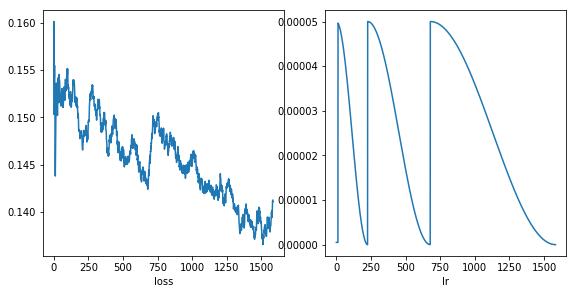

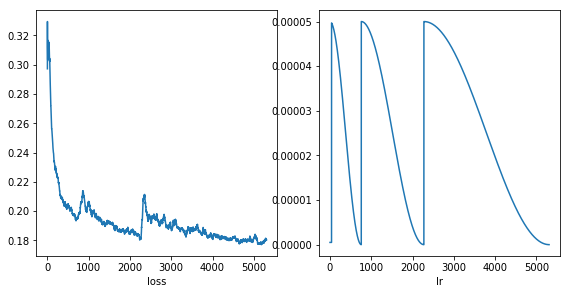

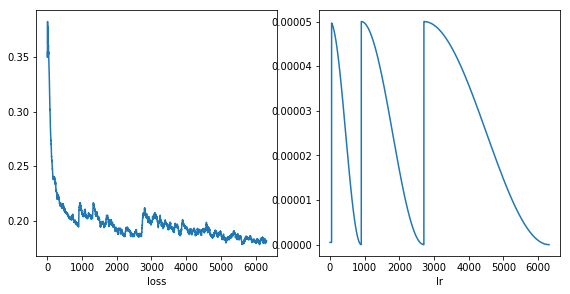

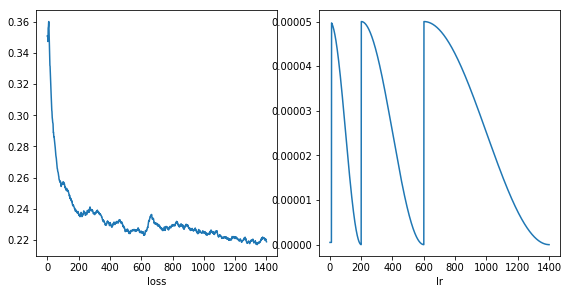

In [30]:
lr = 1e-4
lrs = np.array([lr/10, lr]) / 2
wd = 0.025
wds = [wd/3, wd]
train_on_full_dataset(3, lrs, wds, False, use_wd_sched=False, save_starter='full_dataset_in_0') # epoch 3 means actually 3x2=6 because cyc_len=2

Find learning rate

In [ ]:
learn, denorm = learner_on_dataset(datapaths[1])

In [ ]:
learn, denorm = load_backup_learn()

In [ ]:
!ls data/models

In [ ]:
learn.freeze_to(1)
learn.lr_find()
learn.sched.plot()

In [ ]:
%%time
## 24 workers
lr = 1e-5
lrs = np.array([lr/3, lr])
train_and_plot(1, 'vegas', epoch=2, lrs=lrs, wds=wds, use_wd_sched=False, cycle_len=8, use_clr=None, best_save_name='autosaved_2')

In [32]:
%%time
tta = learn.TTA()

CPU times: user 45min 43s, sys: 4min 20s, total: 50min 3s
Wall time: 1min 27s


In [ ]:
%%time
preds = learn.predict()

In [ ]:
plot_worse_cross_entropy(tta, shift=2000, n_ims=9)

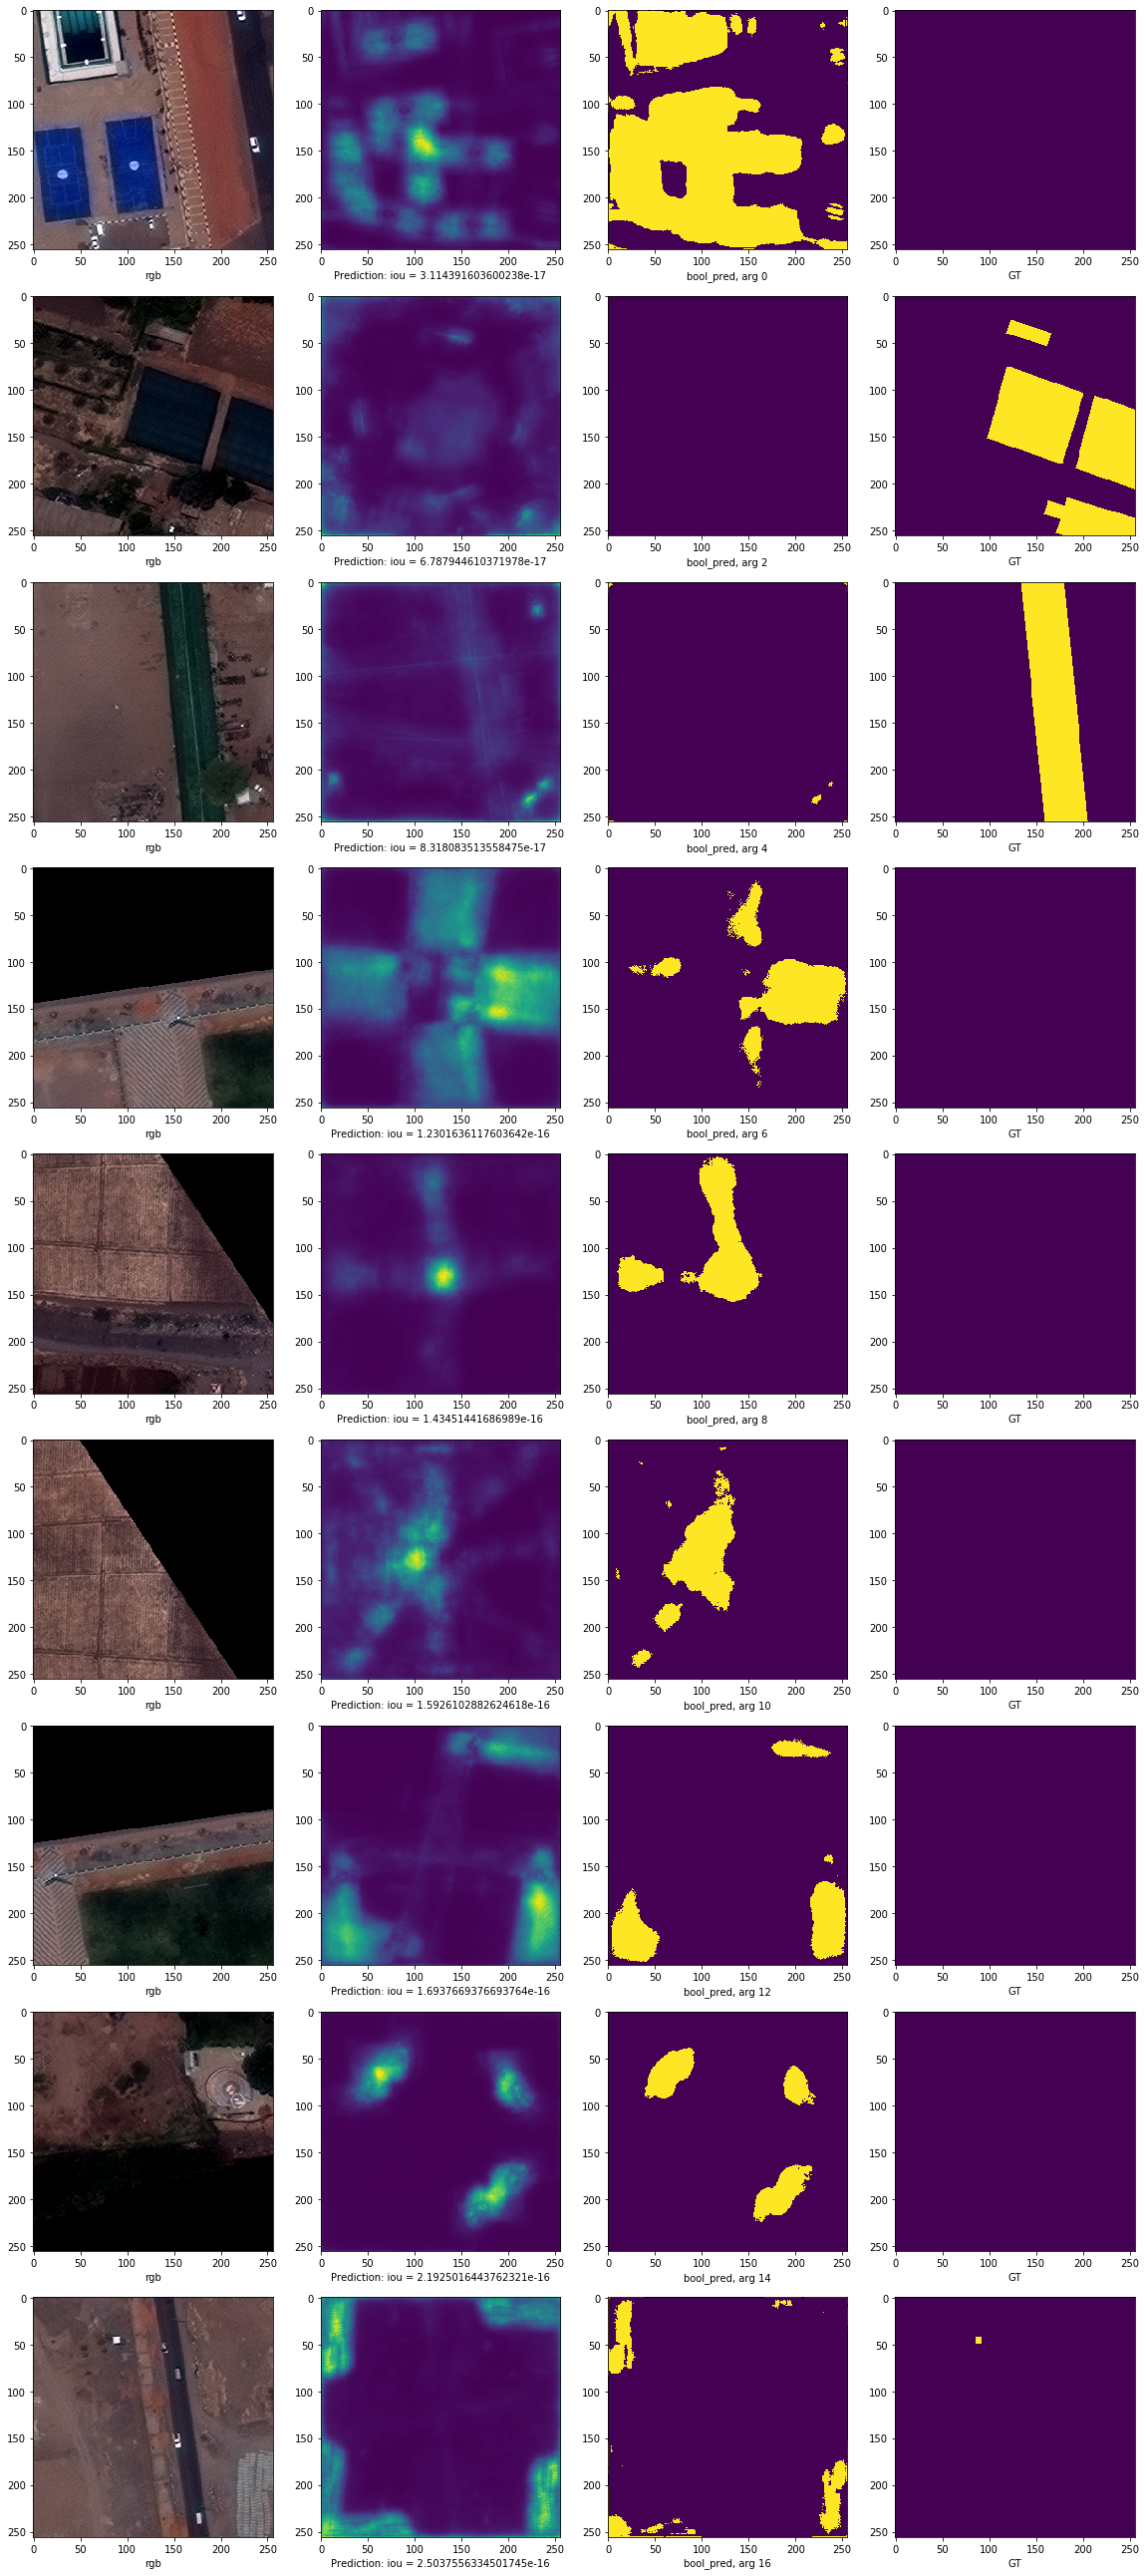

In [73]:
plot_worse_iou(tta, shift=2000)